In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acf
import numpy as np

Based on the 'retail-demand-analysis' project, Center №13 was identified as the most active in terms of order frequency and volume. Therefore, it has been selected as the primary focus for our forecasting model since:

1. More data → More orders means more historical data for the model, which means better forecast quality.
2. Pattern stability → Stores with high activity tend to have more predictable trends.
3. Minimize outliers → Stores with high costs but low orders may have unstable purchases, which will make forecasting more difficult.

1. Data import and first acquaintance with data

In [2]:
df = pd.read_csv('Food Demand Dataset/food_demand.csv')
df_orders = df[df['center_id'] == 13].reset_index(drop = True)
df_orders

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1171094,1,13,1885,135.86,122.28,0,1,2132
1,1068455,1,13,1993,134.86,122.28,0,1,2418
2,1105491,1,13,2539,133.86,133.86,0,0,474
3,1486384,1,13,2139,337.62,437.53,0,0,123
4,1345938,1,13,2631,252.23,437.47,0,0,162
...,...,...,...,...,...,...,...,...,...
7041,1385493,145,13,1543,484.03,485.03,0,0,270
7042,1076678,145,13,2304,486.03,485.03,0,0,149
7043,1012260,145,13,2664,241.59,335.62,0,0,770
7044,1268089,145,13,2569,241.53,337.56,0,0,798


In [3]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7046 non-null   int64  
 1   week                   7046 non-null   int64  
 2   center_id              7046 non-null   int64  
 3   meal_id                7046 non-null   int64  
 4   checkout_price         7046 non-null   float64
 5   base_price             7046 non-null   float64
 6   emailer_for_promotion  7046 non-null   int64  
 7   homepage_featured      7046 non-null   int64  
 8   num_orders             7046 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 495.6 KB


1.1. The center description

In [4]:
df_center = pd.read_csv('Food Demand Dataset/fulfilment_center_info.csv')
df_center[df_center['center_id'] == 13]

,center_id,city_code,region_code,center_type,op_area
1,13,590,56,TYPE_B,6.7


In [5]:
num_meals = df_orders['num_orders'].sum()
print(f'Total number of products ordered by center 13: {num_meals}')

Total number of products ordered by center 13: 4296545


In [6]:
df_orders['Total costs'] = df_orders.checkout_price * df_orders.num_orders

total_costs_orders = df_orders['Total costs'].sum()
print(f'Total costs of orders for all products by center 13: {total_costs_orders}')

Total costs of orders for all products by center 13: 1127045001.1799998


Thus, the Center №13 based in city №590 and being B-type class made 7 046 orders for 4 296 545 units of products and for a total of 1 127 045 001,18 conventional monetary units over 145 weeks

1.2. The meal description

To create a forecasting model, we will focus on one type of product that was ordered most often or in large volumes

In [7]:
meals_num_orders = df_orders.groupby('meal_id').size().reset_index(name='num_orders')
meals_num_orders = meals_num_orders.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_orders = meals_num_orders.head(10)
top_meal_orders

,meal_id,num_orders
0,1062,145
1,1109,145
2,1198,145
3,1445,145
4,1311,145
5,1778,145
6,1558,145
7,1727,145
8,1754,145
9,2707,145


Since the number of orders for each product is equal, then let's calculate which product was ordered the largest number of units

In [8]:
meals_num_units = df_orders.groupby('meal_id')['num_orders'].sum().reset_index(name='num_orders')
meals_num_units = meals_num_units.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_units = meals_num_units.head(1)
print(f'The product with the highest number of units ordered was meal №{top_meal_units.iloc[0,0]}, amounting to {top_meal_units.iloc[0,1]} units')

The product with the highest number of units ordered was meal №1885, amounting to 334334 units


In [9]:
df_meal = pd.read_csv('Food Demand Dataset/meal_info.csv')
df_meal[df_meal['meal_id'] == 1885]

,meal_id,category,cuisine
0,1885,Beverages,Thai


To sum up, the most popular product in Center №13 was the Thai drink №1885. Given it was consistently ordered over 145 weeks with a total volume of 334 334 units across 145 separate orders, it demonstrates both long-term demand stability and high order frequency.

These characteristics make it a strong candidate for time series forecasting, as the volume and regularity of historical data provide a solid foundation for building a reliable and accurate predictive model.

2. Data cleaning

Due to the 'retail-demand-analysis' project we can note that:
1) There is no one column in the table that has NaN value;
2) No duplicate column/row values ​​in the table;
3) Column 'id' has only unique values.

We need:
1) Delete unnecessary columns and rows;
2) Rename columns so they express clear meaning.

In [10]:
# Remove unrequired rows
df_orders = df_orders.loc[df_orders['meal_id'] == 1885]

In [11]:
# Remove unrequired columns
del df_orders['emailer_for_promotion']
del df_orders['homepage_featured']
del df_orders['center_id']
del df_orders['meal_id']

In [12]:
# Rename columns
df_orders = df_orders.rename(columns={'num_orders': 'num_units'})

In [13]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 0 to 6995
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              145 non-null    int64  
 1   week            145 non-null    int64  
 2   checkout_price  145 non-null    float64
 3   base_price      145 non-null    float64
 4   num_units       145 non-null    int64  
 5   Total costs     145 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 7.9 KB


In [14]:
df_orders

,id,week,checkout_price,base_price,num_units,Total costs
0,1171094,1,135.86,122.28,2132,289653.52
45,1295835,2,135.86,121.28,1891,256911.26
90,1429724,3,133.86,122.28,2067,276688.62
135,1197234,4,134.86,122.28,2472,333373.92
180,1469105,5,143.56,120.28,1863,267452.28
...,...,...,...,...,...,...
6791,1057276,141,151.38,150.38,3012,455956.56
6842,1296689,142,151.38,150.38,2848,431130.24
6893,1255671,143,150.41,149.38,3172,477100.52
6944,1038807,144,150.38,151.38,2403,361363.14


3. Modeling

In [48]:
df_data = pd.DataFrame({'week': df_orders.week,'num_units': df_orders.num_units})
df_data

,week,num_units
0,1,2132
45,2,1891
90,3,2067
135,4,2472
180,5,1863
...,...,...
6791,141,3012
6842,142,2848
6893,143,3172
6944,144,2403


3.1. Preparation

Creating functions for those actions that will be repeated several times

3.1.1. Graphs

In [44]:
# Plotting graphs with one or two data series
def plot_graph(x, *Ys, title = None, labels = None):                   
    plt.figure(figsize = (6, 4))

    for i, y in enumerate(Ys):
        label = labels[i] if labels and i < len(labels) else f'Dataset {i+1}'
        plt.plot(x, y, label = label)                

    if title:
        plt.title(title, fontsize = 14)
    plt.xlabel('Week', fontsize = 12)
    plt.ylabel('Amount of units', fontsize = 12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [72]:
# Plotting autocorrelation and partial autocorrelation graphs
def autoreg(data, lag = 25):         
    plot_acf(data, lags = lag)       
    plot_pacf(data, lags = lag)
    plt.show()

3.1.2. Tests

In [83]:
# KPSS test
def test_by_KPSS(data, regression = 'c'):                 
    kpsstest = kpss(data, regression = regression)                  
    print ('Results of KPSS Test: %f' % kpsstest[0])
    print('p-value: %f' % kpsstest[1])
    print('Critical Values:')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        print('\t%s: %.3f' % (key, value))

In [84]:
# Augmented Dickey–Fuller test (ADF)
def test_by_AdFuller(data):                            
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

3.2. Analysis of initial data

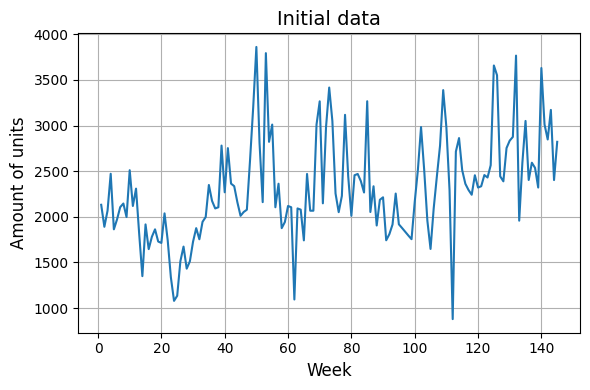

In [45]:
plot_graph(df_orders.week, df_orders.num_units, title = 'Initial data')

In [74]:
num_units = pd.Series(df_orders['num_units'].values)

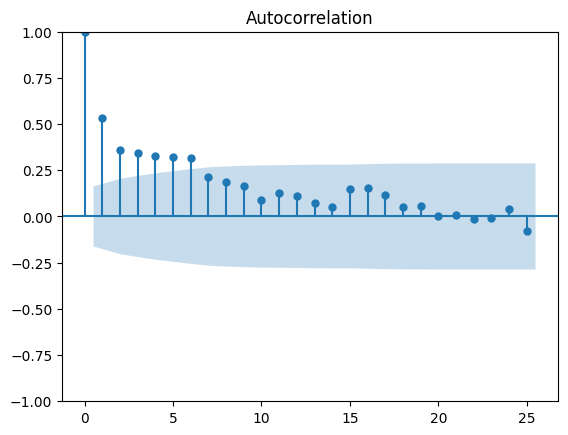

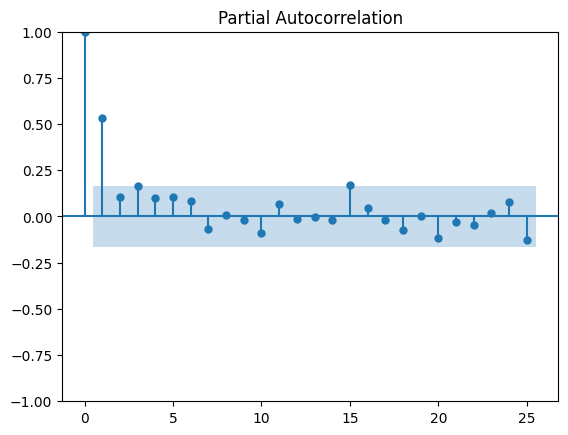

In [76]:
autoreg(num_units)

In [85]:
test_by_KPSS(num_units)
print('')
test_by_AdFuller(num_units)

Results of KPSS Test: 0.745295
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Statistic: -3.868856
p-value: 0.002276
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


C:\Users\user\AppData\Local\Temp\ipykernel_20028\3308023662.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(data, regression = regression)
